# Introduction
Contains notes on study of various optimisation algorithms for training deep neural networks.
Not intended as a learning resource.

## Theory

### Some notation:
- $\Theta$: The parameter space of a machine learning model.
- $f_{\theta}(\cdot)$ - The model to train. Given a feature vector, it predicts a target variable (see below)
- $\mathcal{D}$: A dataset for supervised learning, formally a set of $n$ pairs, $(X_i,y_i)$, where $X_i$ denotes a feature vector (input variable), and $y_i$ is the corresponding target variable.
- $\widehat{y}_i$ - The model prediction given a feature vector, $X_i$.
- $L(y_i,\widehat{y_i})$ - The loss function (essentially a distance function between actual target variable and that predicted by model.
- $C$ - The cost function, which measures a model's error over a group of training instances ($C = \sum_{i} L(y_i,\widehat{y}_i)$).
- $\nabla_{\theta_{t}}C$ - The derivative of the cost function w.r.t the model parameters at time step $t$. A vector.

**What is an optimiser?** - Our ultimate aim in training a neural network is to find the optimal parameterised function $f_{\theta}$, for a given task. This is reduces to searching over the parameter space for $\theta$ for an optimal set of parameters, $\theta_{opt}$. Given that the parameter space can be millions or billions of dimensions in current neural networks, this search must be performed intelligently. This is the job of our optimisation algorithm. 

### Vanilla gradient descent (VGD)

There are essentially three variants of gradient descent. They are characterised by the number of samples in the training dataset that are used to compute the cost function (which is in turn needed for the gradient vector, and paramater updates). They are as follows:

1. **Batch gradient descent**: Uses *all* the training instances in the training dataset to compute the cost function. Whilst this gives the best possible reflection of model performance, it is expensive to implement for large training datasets. 
2. **Stochastic gradient descent**: The converse of batch gradient descent, stochastic gradient descent uses just *one* training instance to calculate the cost, with this training instance chosen randomly. Whilst cheap to implement, this method leads to very noisy parameter updates (movement over parameter space follows no clear direction over short timescales), due to the inaccuracy rising from modelling model performance across the whole training dataset with its loss on just one training instance.
3. **Mini-batch gradient descent**: An attempt at achieving the best of both worlds with regards to batch/stochastic gradient descent. One chooses a batch size, $m$, and the cost is computed as the average over $m$ randomly chosen training instances.

<center>
    <figure>
        <img src='Images/vanilla_grad_descent.png' width=400 alt='missing' />
        <figcaption>Src: https://towardsdatascience.com/improving-vanilla-gradient-descent-f9d91031ab1d</figcaption>
    </figure>
</center>


However, the following challenges are present in all versions of vanilla gradient descent:
1. **Difficulty in choosing learning rate** - A large learning rate may lead to no convergence, with the optimiser instead just oscillating around some (global/local) minimum. Too small a learning rate runs the risk of getting stuck in local minima, as well as extremely slow convergence (and therefore large training times). 
2. **Non-adaptive learning rate schedules** - One quick fix to problem (1) is to have the learning rate vary as a function of time, or epoch number. This is known as setting a learning rate schedule. Whilst this sometimes works, the learning rate must be set in advance of the training process, meaning they cannot adapt to the datasets characteristics (for example, it would be desirable to have a learning rate that adapts to the magnitude of the gradient).
3.) **Global learning rates** - In the methods given above, one learning rate is applied to all parameters. We would like a learning rate that accounts for this.
4.) **Getting stuck in local minima** - For highly non-convex functions, it is likely that variants of gradient descent will get stuck in suboptimal local minima. We would like to develop techniques that encourage convergence toward global minima in parameter space.


### Momentum:

As hinted above, some directions in parameter space may be considerably steeper than others. This can lead to oscillation without real progress towards local/global minimum when using VGD. The momentum adaptation to gradient descent gives the parameter update some inertia in the direction that it is moving, similar to that which a heavy ball has when rolling down a slope. This is shown in the figure below:

<center>
    <figure>
        <img src='Images/momentum_img.png' width=600 alt='missing' />
        <figcaption></figcaption>
    </figure>
</center>

Formally, we can define the weight update for gradient descent with a momentum adaptation as follows:

\begin{align*}
\theta_{t+1} = \theta_{t} + \Delta \theta_{t} \\
\Delta\theta_t = -\eta \nabla_{\theta_t}C + \gamma \Delta \theta_{t-1}
\end{align*}

In short, there is an additional term that incorporates the direction of the parameter update from the previous step, giving the current parameter update 'momentum' in this direction. $\gamma$ is a user defined hyperparameter.


### Adaptive Momentum (Adagrad):

Adagrad adapts the learning rate to two properties of the training process:
1. The scale of the gradient along directions in parameter space.
2. The elapsed training time. 

As a result, rather than a scalar learning rate, we now have a vector learning rate $\mathbf{\eta}$. The Adagrad weight update for the $i$th parameter, at time $t$ takes the form:

\begin{align*}
\theta_{t+1,i} = \theta_{t,i} - \eta_{t,i} g_{t,i} \\
g_{t,i} = (\nabla_{\theta_{t}}C)_i
\end{align*}

$g_{t,i}$ is just the $i$th component of the gradient vector. <br>
We need to define two further terms. First, we introduce the diagonal matrix $G_t \in \mathbb{R}^{d \times d}$, where $d$ is the dimension of parameter space. The $i$th nonzero element of $G_t$, $G_{t,ii}$ is the sum of the squares of the gradients in the direction of $\theta_{i}$ from time $t=1$ up to time step $t$: $G_{t,ii} = \sum_{j=1}^{t-1}g_{j,i}^{2}$. We can then use this term to scale the learning rate accordingly, yielding:

$$
\eta_{t,i} = \frac{\eta_0}{\sqrt{G_{t,ii} + \epsilon}}
$$

where $\epsilon$ is some small positive number to prevent division by zero errors and $\eta_0$ is a hyperparameter.


### RMSProp
Observe that the adaptive learning rates of the Adagrad optimiser will converge to $0$ in the limit of long training times. This is because the denominator is simply the square root of the accumulated gradients squared from timestep $1$ to $t$, which is a monotonically increasing function.
It is undesirable for the learning rate to tend toward $0$, as this reduces the amount of learning that can be done by the model in the latter stages of training. The RMSprop optimiser looks to solve this by normalising the initial hyperparameter $\eta$ with the average of the squared gradients *over the past $w$ timesteps only*. This is achieved with an *exponentially weighted average* over the gradients so far.

To formalise this, we start with a general form for a decaying, adaptive learning rate (we do this for a single parameter, leaving out the parameter subscript $i$ for this example):
$$
\eta_t = \frac{\eta_0}{\sqrt{\alpha_t + \epsilon}} 
$$
Recall that for Adagrad, $\alpha_t = \sum_{j=1}^t g_j^2$, where $g_j$ is the gradient at the $j$ th timestep. <br>
For RMSprop, we add a decay factor to give gradients from previous time steps lower weight compared to the most recent gradients. A mathematical statement of this concept is:
$$\alpha_t = \sum_{j=1}^t \rho^{t-j} \cdot g_j^2$$ 
where $0<\rho<1$. This allows us to give $\alpha_t$ a recursive definition, namely $\alpha_t = \rho \alpha_{t-1} + g_t^2$.

RMSprop uses a slight variation on the formalisation above, with $\alpha_t = \rho \alpha_{t-1} + (1-\rho)g_t^2$. The scaling of $g_t^2$ by $(1-\rho)$ allows the user to give the normalisation factor $\alpha_t$ a long or short term memory;  $\rho \approx 0$ means that the normalisation term is dependent on the most recent gradients, whereas $\rho \approx 1$ leads to a learning rate that is influenced by gradients many time steps ago.

The denominator of the RMS learning rate, being a running weighted average of the 

### AdaDelta

The function of a user-defined learning rate $\eta$ is to 'guess' the scale of the loss landscape. Do most valleys and hills in the landscape exist on a scale of 0.01,0.1,1.0,10,100 etc units?

All other optimisation algos presented here are first-order methods - use first derivative of C w.r.t theta only. This messes up gradient units though.

### Adam



### Sources
- https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/#:~:text=While%20training%20the%20deep%20learning,loss%20and%20improve%20the%20accuracy.
- https://ruder.io/optimizing-gradient-descent/

## Experiments
Comparing the optimisers above on a simple MNIST image classifier, via their learning curves.

In [2]:
## Imports
import time
import matplotlib.pyplot as plt

import torch;torch.manual_seed(1)
import torchvision
import torch.optim as optim
import torch.nn as nn
from torch.nn import functional as F

device = torch.device("cude:0" if torch.cuda.is_available() else "cpu")

In [3]:
##Data processing
train_batch_size = 64
test_batch_size = 1000
mean = 0.1307; std = 0.3081 #global mean and std of MNIST dataset

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
    (mean,),(std,))])

train_dataset = torchvision.datasets.MNIST('',train=True,
                                     download=True,transform=transform)
train_dataset,valid_dataset = torch.utils.data.random_split(train_dataset,[50000,10000])

test_dataset = torchvision.datasets.MNIST('',train=False,
                                          download=True,transform=transform)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           shuffle=True,
                                           batch_size = train_batch_size)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           shuffle=True,
                                           batch_size=train_batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           shuffle=True,
                                           batch_size = test_batch_size)

In [4]:
##Create the network


#Creating network of size [input, 128,64,32,16,10]

imgs,targets = next(iter(train_loader))
input_dims = tuple((imgs[0][0,:,:]).size())


class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(input_dims[0]*input_dims[1],128)
        self.l2 = nn.Linear(128,64)
        self.l3 = nn.Linear(64,32)
        self.l4 = nn.Linear(32,10)
    
    
    def forward(self,x):
        
        x = x.squeeze(1).view(-1,784)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        
        probs = F.softmax(x,dim=1)
        
        return x



 Training with SGD
Training complete for epoch 1.
Train loss: 1.5592936520914897 
Validation loss 0.5612488842693863 

Training complete for epoch 2.
Train loss: 0.4195041151150413 
Validation loss 0.3482708727857869 

Training complete for epoch 3.
Train loss: 0.3141158416752925 
Validation loss 0.2873607712566473 

Training complete for epoch 4.
Train loss: 0.2611422307856019 
Validation loss 0.25200035826415773 

Training complete for epoch 5.
Train loss: 0.22266675697644348 
Validation loss 0.21150056462568842 

Training complete for epoch 6.
Train loss: 0.19243391246899313 
Validation loss 0.2004206870344414 

Training complete for epoch 7.
Train loss: 0.16940635678303592 
Validation loss 0.18438528603903806 

Training complete for epoch 8.
Train loss: 0.15021829141299134 
Validation loss 0.1615000026549693 

Training complete for epoch 9.
Train loss: 0.13391931339398103 
Validation loss 0.14730099422536838 

Training complete for epoch 10.
Train loss: 0.12063513742640729 
Valid

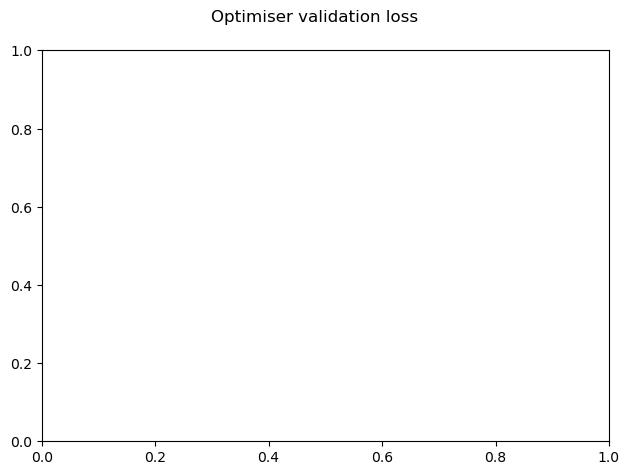

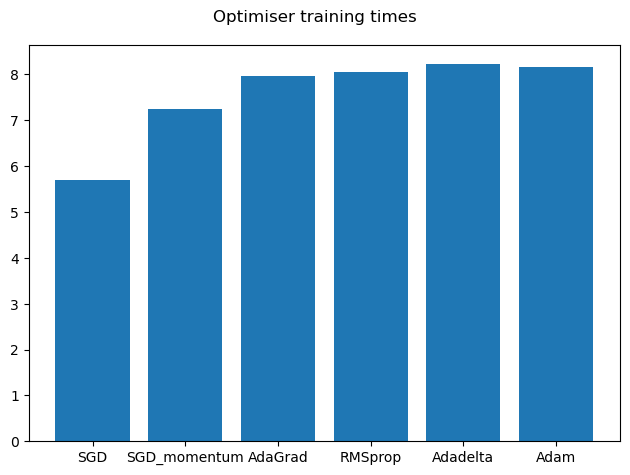

In [23]:


lr = 0.01
momentum = 0.8

n_epochs = 10
objective = nn.CrossEntropyLoss()

model = Net()
model = model.to(device)


optimisers = {'SGD':optim.SGD(params=model.parameters(),lr=lr),
             'SGD_momentum':optim.SGD(params=model.parameters(),lr=lr,momentum=momentum),
             'AdaGrad':optim.Adagrad(params=model.parameters(),lr=lr), #normalise lr with sum of past gradients
             'RMSprop':optim.RMSprop(params=model.parameters(),lr=lr,alpha=0.9), #normalise with weighted sum of past gradients
             'Adadelta':optim.Adadelta(params=model.parameters(),rho=0.9), #like RMSprop, but use correct units
              'Adam':optim.Adam(params=model.parameters(),lr=lr,betas=(0.9,0.999)) #yeah
             }


def optimiser_train(optimiser,n_epochs=3,plot=False):
    '''Return optimiser loss data on MNIST dataset for model defined above.
    We want to train for n epochs on optimiser, and record loss + time.
    '''
    train_loss_data = []
    val_loss_data = []
    start_time = time.time()
    
    for epoch in range(n_epochs):
        
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        for idx,(inputs,targets) in enumerate(train_loader):
            
            inputs = inputs.to(device); targets = targets.to(device)
            optimiser.zero_grad()
            
            model_output = model(inputs)
            loss = objective(model_output,targets)
            loss.backward() #compute gradients
            optimiser.step() #update parameters
            
            epoch_train_loss+=loss.item()
            
        epoch_train_loss/=(idx+1) #normalise loss for number of iterations in batch. If not, cannot compare between train and val
        
        for idx,(inputs,targets) in enumerate(valid_loader):
            inputs = inputs.to(device); targets = targets.to(device)
            
            with torch.no_grad(): #no need to compute backward graph as no update made
                model_output = model(inputs)
            loss = objective(model_output,targets)
            
            epoch_val_loss+=loss.item()
            
        epoch_val_loss/=(idx+1)
            
        
        train_loss_data.append(epoch_train_loss)
        val_loss_data.append(epoch_val_loss)
        print('Training complete for epoch {}.\n'
        'Train loss: {} \n'
        'Validation loss {} \n'.format(epoch+1,train_loss_data[-1],val_loss_data[-1]))
        
    
     
    end_time = time.time()
    training_time = round((end_time-start_time),2)
    
    test_loss = 0
    for idx,(inputs,targets) in enumerate(test_loader):
        inputs = inputs.to(device); targets = targets.to(device)
        
        model.eval()
        model_output = model(inputs)
        loss = objective(model_output,targets)
        test_loss+=loss.item()
    test_loss/=(idx+1)
    
    print('Finished training for optimiser {}'.format(optimiser))
    print('Test loss: {}'.format(test_loss))
    print('Training time: {} seconds'.format(training_time))

        
        
    return train_loss_data,val_loss_data, training_time
    

fig1,ax1 = plt.subplots();
fig2,ax2 = plt.subplots();
fig1.suptitle('Optimiser validation loss')
fig2.suptitle('Optimiser training times')

training_times = []

for name in list(optimisers.keys()):
    
    print('\n\n Training with {}'.format(name))
    _,val_loss,training_time = optimiser_train(optimisers[name],n_epochs=n_epochs)
    ax.plot(list(range(n_epochs)),val_loss,label=name)
    training_times.append(training_time)
    
ax2.bar(list(optimisers.keys()),times)

fig1.tight_layout();
fig2.tight_layout()
